In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('matplotlib').setLevel(logging.WARNING)

import pyglstudy as gl
from pyglstudy.group_lasso import *
from pyglstudy.group_basil import group_basil
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm

In [6]:
def analyze_base(diag):
    logging.debug(f"Time Init:          {diag['time_init'][0]}")
    logging.debug(f"Time Init Fit:      {diag['time_init_fit'][0]}")
    logging.debug(f"Time Screen:        {np.sum(diag['time_screen'])}")
    logging.debug(f"Time Fit:           {np.sum(diag['time_fit'])}")
    logging.debug(f"Time KKT:           {np.sum(diag['time_kkt'])}")
    logging.debug(f"Time Transform:     {diag['time_transform'][0]}")
    logging.debug(f"Time Untransform:   {diag['time_untransform'][0]}")
    
    gl_diag = diag['time_group_lasso']
    time_strong = [np.sum(d['time_strong_cd']) for d in gl_diag]
    time_active = [np.sum(d['time_active_cd']) for d in gl_diag]
    logging.debug(f"Time Strong Total:  {np.sum(time_strong)}")
    logging.debug(f"Time Active Total:  {np.sum(time_active)}")

def analyze_cov(diag):
    analyze_base(diag)
    
    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd', 'time_active_grad']
    titles = ['Strong CD Time', 'Active CD Time', 'Active Gradient Update Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Iteration")
            ax.set_ylabel("Time (s)")
    plt.show()
    
def analyze_naive(diag):
    analyze_base(diag)

    time_gls = diag['time_group_lasso']
    types = ['time_strong_cd', 'time_active_cd']
    titles = ['Strong CD Time', 'Active CD Time']

    fig, axes = plt.subplots(1, len(types), layout='constrained', figsize=(10,4))
    for j in range(len(axes)):
        ax = axes[j]
        type_j = types[j]
        for i in tqdm(range(len(time_gls))):
            ax.plot(time_gls[i][type_j], alpha=0.7)
            ax.set_title(titles[j])
            ax.set_xlabel("CD Iteration")
            ax.set_ylabel("Time (s)")
    plt.show()

In [7]:
n = 100
p = 10000
n_groups = int(p/100)
seed = 0

np.random.seed(seed)
X, beta, y, groups, group_sizes = generate_group_lasso_data(
    n, p, n_groups, rho=-0.01, svd_transform=False
).values()

In [8]:
# cov
#out_cov = group_basil(X, y, groups, group_sizes, method='cov', max_n_cds=int(5e6))

In [10]:
# naive
out_naive = group_basil(X, y, groups, group_sizes, method='naive', max_n_cds=int(1e5))
diag_naive = out_naive['diagnostic']

TypeError: group_basil_naive__(): incompatible function arguments. The following argument types are supported:
    1. (arg0: numpy.ndarray[numpy.float64[m, n], flags.writeable, flags.f_contiguous], arg1: numpy.ndarray[numpy.float64[m, 1], flags.writeable], arg2: numpy.ndarray[numpy.int32[m, 1], flags.writeable], arg3: numpy.ndarray[numpy.int32[m, 1], flags.writeable], arg4: float, arg5: numpy.ndarray[numpy.float64[m, 1], flags.writeable], arg6: List[float], arg7: int, arg8: int, arg9: bool, arg10: bool, arg11: bool, arg12: bool, arg13: int, arg14: int, arg15: int, arg16: float, arg17: float, arg18: float, arg19: float, arg20: int, arg21: float, arg22: int) -> dict

Invoked with: array([[ 0.36250649,  0.22475308,  0.28318974, ...,  0.23654129,
         0.18101221,  0.31544646],
       [-0.13029388, -0.19403639,  0.06521357, ..., -0.11566324,
        -0.21683212, -0.14285943],
       [ 0.08996305,  0.05657994,  0.13925812, ..., -0.09601049,
         0.15528964,  0.18343398],
       ...,
       [ 0.14973307, -0.20535883,  0.02996916, ...,  0.05237457,
        -0.15137519, -0.01886355],
       [ 0.03081818,  0.17665129, -0.09051541, ...,  0.20389064,
         0.08243492, -0.02573418],
       [-0.10307089,  0.02542464,  0.20530351, ..., -0.07739799,
         0.09147792,  0.14168245]]), array([-1.52744205e+01,  2.88523083e+00,  1.75748819e+01, -1.25586021e+01,
       -4.81887178e+00,  3.84511235e+00, -5.93397207e+00,  2.06195019e+01,
       -1.58244371e+01,  1.99136435e+01, -2.02119857e-02,  1.24911793e+01,
        9.54889959e+00,  1.19469412e+01,  5.58073800e+00,  2.24234903e+01,
        1.07175506e+01,  1.94191082e+00, -3.82348840e+00,  1.14302419e+01,
       -2.75111062e+01,  1.21050426e+01, -2.53863525e+01,  8.25457074e+00,
        2.48751966e+00, -6.64377859e+00,  2.52231005e-01,  3.66598170e+00,
       -7.81779437e+00, -1.28761814e+01,  2.11249614e+00,  1.14770804e+01,
        1.51424436e+01, -1.26998940e+01,  1.18684062e+01,  1.63915900e+01,
        5.37433010e+00, -2.24847318e+00,  8.49675399e+00,  1.29804818e+00,
        6.57160340e+00, -4.27953151e+00, -2.42377689e+01,  1.43269156e+00,
        2.16256598e+01,  1.54704293e+00,  1.08133550e+01, -8.47935608e+00,
        1.56578860e+00,  3.09436708e+01,  2.17725852e+00, -9.38765682e-01,
        1.13689154e+01,  2.29043109e-01, -1.10104563e+01,  9.19418450e+00,
       -1.28003373e+01, -1.83087305e+01, -6.08934996e+00,  1.27651754e+00,
        1.21810872e+01,  4.38349259e+00,  2.23441712e+01,  3.32322980e+00,
       -9.88587763e+00, -3.84072641e+00, -3.39277454e-01, -2.15704769e+00,
       -6.72951283e+00, -5.60784455e-01,  4.40071972e+00,  3.38488878e+00,
        4.33756781e+00, -6.72775417e+00,  8.49783066e+00, -1.39560762e+01,
       -4.01722510e-01,  6.84285738e-01, -1.39232911e+01,  2.75183896e+00,
        3.82624749e+00, -3.49063792e+00, -7.55800261e+00,  6.70724858e+00,
       -1.48706287e+00, -4.42308833e+00, -9.17087625e+00,  7.84276137e+00,
        8.25884360e+00,  5.24624743e-01,  1.33063340e+01, -5.07886356e+00,
       -5.43532932e+00, -1.52029975e+01,  5.69943481e-01, -1.69325838e+00,
        9.81505902e+00,  8.74360506e+00, -1.72630655e+00, -2.52103741e+01]), array([   0,   24,  177,  270,  283,  602,  620,  812,  882, 1000, 1096,
       1162, 1217, 1228, 1243, 1329, 1412, 1472, 1474, 1592, 1598, 1675,
       1837, 1971, 2068, 2096, 2112, 2156, 2363, 2520, 2724, 2922, 2924,
       3223, 3369, 3609, 3647, 3749, 4105, 4237, 4272, 4346, 4517, 4527,
       4537, 4538, 4794, 4844, 4884, 4940, 5103, 5247, 5272, 5387, 5411,
       5470, 5557, 5639, 5865, 6080, 6194, 6303, 6405, 6918, 6930, 6955,
       7042, 7071, 7157, 7184, 7279, 7294, 7295, 7426, 7540, 7721, 7811,
       7825, 8008, 8035, 8209, 8218, 8388, 8455, 8537, 8749, 8863, 8900,
       8984, 9034, 9055, 9158, 9340, 9353, 9492, 9586, 9820, 9862, 9973,
       9978], dtype=int32), array([ 24, 153,  93,  13, 319,  18, 192,  70, 118,  96,  66,  55,  11,
        15,  86,  83,  60,   2, 118,   6,  77, 162, 134,  97,  28,  16,
        44, 207, 157, 204, 198,   2, 299, 146, 240,  38, 102, 356, 132,
        35,  74, 171,  10,  10,   1, 256,  50,  40,  56, 163, 144,  25,
       115,  24,  59,  87,  82, 226, 215, 114, 109, 102, 513,  12,  25,
        87,  29,  86,  27,  95,  15,   1, 131, 114, 181,  90,  14, 183,
        27, 174,   9, 170,  67,  82, 212, 114,  37,  84,  50,  21, 103,
       182,  13, 139,  94, 234,  42, 111,   5,  22], dtype=int32), 1, array([ 4.89897949, 12.36931688,  9.64365076,  3.60555128, 17.8605711 ,
        4.24264069, 13.85640646,  8.36660027, 10.86278049,  9.79795897,
        8.1240384 ,  7.41619849,  3.31662479,  3.87298335,  9.2736185 ,
        9.11043358,  7.74596669,  1.41421356, 10.86278049,  2.44948974,
        8.77496439, 12.72792206, 11.5758369 ,  9.8488578 ,  5.29150262,
        4.        ,  6.63324958, 14.38749457, 12.52996409, 14.28285686,
       14.07124728,  1.41421356, 17.29161647, 12.08304597, 15.49193338,
        6.164414  , 10.09950494, 18.86796226, 11.48912529,  5.91607978,
        8.60232527, 13.07669683,  3.16227766,  3.16227766,  1.        ,
       16.        ,  7.07106781,  6.32455532,  7.48331477, 12.76714533,
       12.        ,  5.        , 10.72380529,  4.89897949,  7.68114575,
        9.32737905,  9.05538514, 15.03329638, 14.6628783 , 10.67707825,
       10.44030651, 10.09950494, 22.64950331,  3.46410162,  5.        ,
        9.32737905,  5.38516481,  9.2736185 ,  5.19615242,  9.74679434,
        3.87298335,  1.        , 11.44552314, 10.67707825, 13.45362405,
        9.48683298,  3.74165739, 13.52774926,  5.19615242, 13.19090596,
        3.        , 13.03840481,  8.18535277,  9.05538514, 14.56021978,
       10.67707825,  6.08276253,  9.16515139,  7.07106781,  4.58257569,
       10.14889157, 13.49073756,  3.60555128, 11.78982612,  9.69535971,
       15.29705854,  6.4807407 , 10.53565375,  2.23606798,  4.69041576]), [], 100, 5, True, True, False, 5, 10000, 100000, 1e-07, 0.001, 0.001, 1e-08, 100, 0.01, 16

DEBUG:root:Time Init:          0.051781073000000004
DEBUG:root:Time Init Fit:      0.04921761
DEBUG:root:Time Screen:        0.012972777
DEBUG:root:Time Fit:           2.9809320230000003
DEBUG:root:Time KKT:           1.301148615
DEBUG:root:Time Transform:     1.634969482
DEBUG:root:Time Untransform:   0.00016950800000000002
DEBUG:root:Time Strong Total:  2.9795252230000004
DEBUG:root:Time Active Total:  0.0004191570000000001
100%|██████████| 12/12 [00:00<00:00, 1967.08it/s]


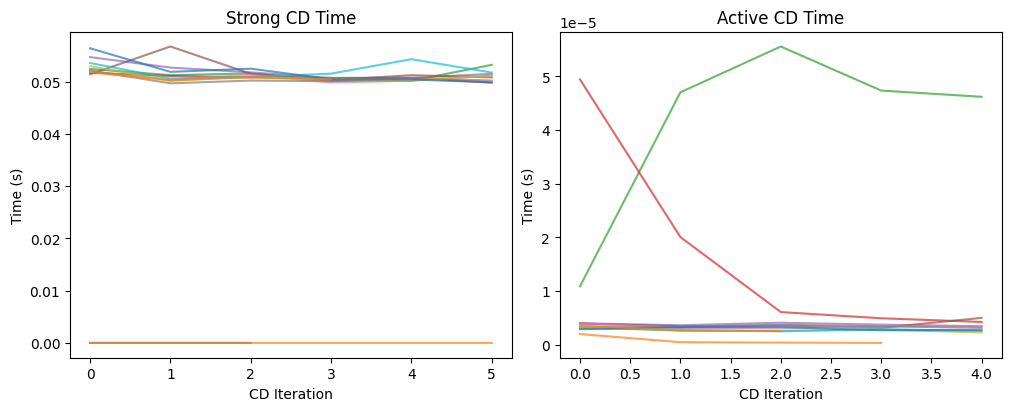

DEBUG:root:Time Init:          0.053405387000000006
DEBUG:root:Time Init Fit:      0.048175651
DEBUG:root:Time Screen:        7.556900000000001e-05
DEBUG:root:Time Fit:           0.007555318
DEBUG:root:Time KKT:           0.11051556300000001
DEBUG:root:Time Transform:     1.564614277
DEBUG:root:Time Untransform:   0.00030971700000000004
DEBUG:root:Time Strong Total:  1.1119e-05
DEBUG:root:Time Active Total:  0.007524009
100%|██████████| 2/2 [00:00<00:00, 1596.92it/s]


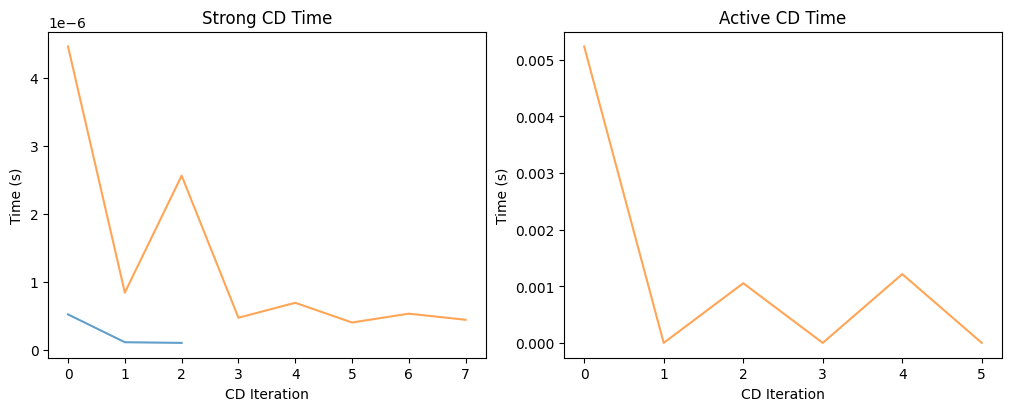

In [28]:
analyze_naive(diag_naive)

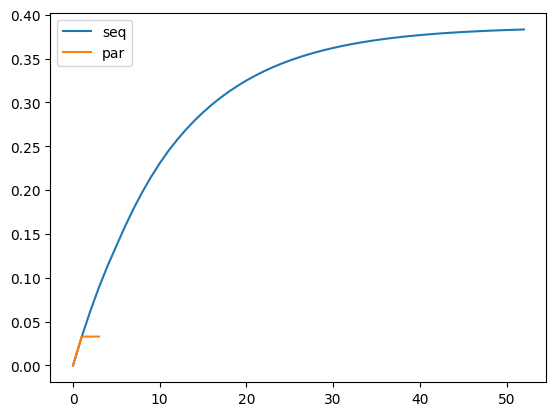

In [29]:
plt.plot(out_naive['rsqs'], label='seq')
plt.plot(out_naive_p['rsqs'], label='par')
plt.legend()

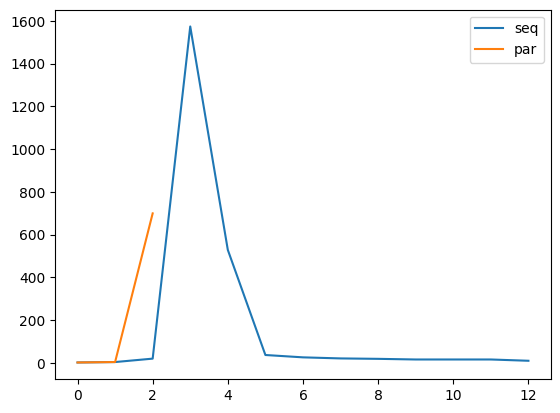

In [26]:
plt.plot(out_naive['diagnostic']['n_cds'], label='seq')
plt.plot(out_naive_p['diagnostic']['n_cds'], label='par')
plt.legend()

In [27]:
out = out_naive
out['betas'], out['error'], out_naive_p['betas'], out_naive_p['error']

(<1000000x53 sparse matrix of type '<class 'numpy.float64'>'
 	with 58 stored elements in Compressed Sparse Column format>,
 '',
 <1000000x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 4 stored elements in Compressed Sparse Column format>,
 '')

100%|██████████| 10000/10000 [00:08<00:00, 1117.92it/s]


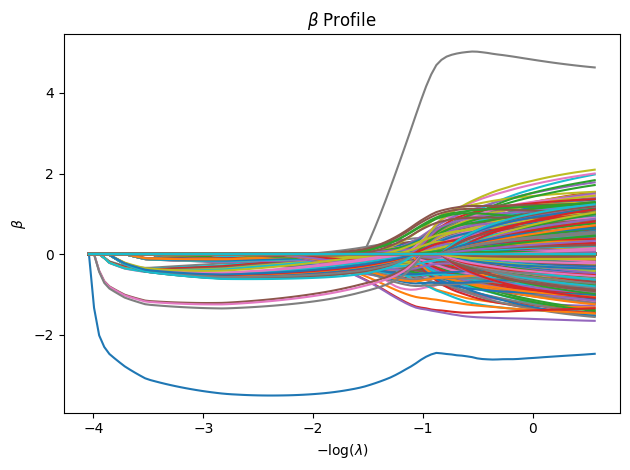

In [20]:
for j in tqdm(range(out['betas'].shape[0])):
    if j % 1 == 0:
        plt.plot(-np.log(out['lmdas']), out['betas'][j].todense().reshape((-1,1)))
plt.title('$\\beta$ Profile')
plt.xlabel('$-\log(\lambda)$')
plt.ylabel('$\\beta$')
plt.tight_layout()
plt.show()

In [ ]:
def run_cvxpy(X, y, groups, group_sizes, alpha, penalty, lmda):
    _, p = X.shape
    beta = cp.Variable(p)
    regul = 0
    for i in range(len(groups)):
        gb = groups[i]
        ge = gb + group_sizes[i]
        bi_norm2 = cp.norm2(beta[gb:ge])
        regul += penalty[i] * (alpha * bi_norm2 + (1-alpha) / 2 * cp.sum_squares(beta[gb:ge]))
    objective = cp.Minimize(0.5 * cp.sum_squares(y - X @ beta) + lmda * regul)
    prob = cp.Problem(objective)
    result = prob.solve()
    return beta.value 


In [ ]:
lmdas = np.array(out['lmdas'])
cvxpy_betas = np.empty((p, len(lmdas)))
for i in tqdm(range(len(lmdas))):
    cvxpy_betas[:, i] = run_cvxpy(X, y, groups, group_sizes, alpha=1, penalty=np.sqrt(group_sizes), lmda=lmdas[i])

In [ ]:
for j in range(cvxpy_betas.shape[0]):
    if j % (10) == 0:
        plt.plot(-np.log(out['lmdas']), cvxpy_betas[j])
plt.title('$\\beta$ Profile')
plt.xlabel('$-\log(\lambda)$')
plt.ylabel('$\\beta$')
plt.tight_layout()
plt.show()